## What are ridge and lasso regressions?

### Motivation

A friend recently wanted a TL;DR on ridge and lasso regressions. It's been some time since I've used either, so I thought I'd implement them in Python using scikit-learn.

### Generate sample datasets

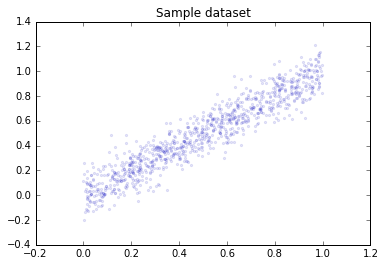

In [10]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
import numpy as np

# Set parameters for sample datasets
_NUM_DATAPOINTS = 1000
_NOISE_PARAMS = [0, .1]

# Convenience function for generating datasets quickly
def generate_sample_dataset(num_datapoints, linear_coeffs, noise_params):
    """
    Generate a sample dataset given information on datapoints, dependent
    variables, and noise.
    """
    # Generate x_i values
    num_features = len(linear_coeffs)
    total_values = num_datapoints * num_features
    x = np.array([random.random() for i in range(total_values)]) \
        .reshape(num_datapoints, num_features)
    # Generate noise values
    mean = noise_params[0]
    var = noise_params[1]
    epsilon = np.array([random.normalvariate(mean, var)
                        for i in range(total_values)]) \
        .reshape(num_datapoints, num_features)
    # Generate y values
    coeffs = np.array(linear_coeffs).reshape(num_features, )
    y = coeffs * x + epsilon
    y = y.sum(axis=1)
    return x, y

# Create sample dataset with single independent variable
linear_coeffs = [1]
x, y = generate_sample_dataset(_NUM_DATAPOINTS, linear_coeffs, _NOISE_PARAMS)

# Plot sample dataset
plt.scatter(x, y, marker='.', color=(0, 0, .75, .1))
plt.title('Sample dataset')
plt.show()

### Fit least squares regression

TL;DR:  minimize residual sum of squares, most familiar linear regression

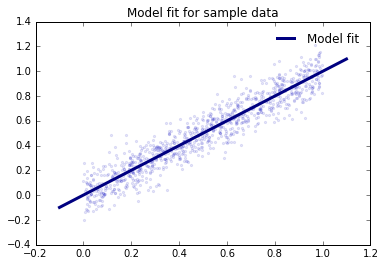

In [11]:
from sklearn import linear_model

# Convenience function for plotting data and model fit
def plot_data_and_model(x, y, model):
    """
    Quickly plot sample data and model fit.
    """
    plt.scatter(x, y, marker='.', color=(0, 0, .75, .1))
    x_model = np.array([-.1, 1.1])
    y_model = x_model * model.coef_[0] + model.intercept_
    plt.plot(x_model, y_model, label='Model fit', color=(0, 0, .5), linewidth=3)
    plt.title('Model fit for sample data')
    plt.legend(loc='best', frameon=False)
    plt.show()

# Fit least squares regression
model_linear = linear_model.LinearRegression()
model_linear.fit(x, y)

plot_data_and_model(x, y, model_linear)

### Fit ridge regression

TL;DR:  less variance, more bias

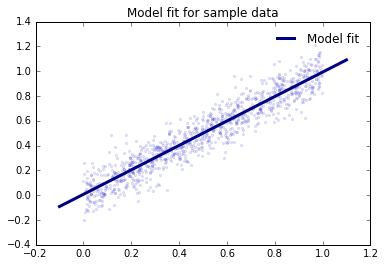

In [12]:
# Fit ridge regression
model_ridge = linear_model.Ridge()
model_ridge.fit(x, y)

plot_data_and_model(x, y, model_ridge)

### Fit lasso regression

TL;DR:  less variance, more bias, variable selection

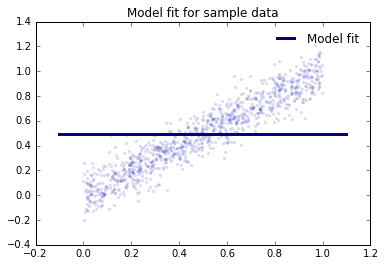

In [13]:
# Fit lasso regression
model_lasso = linear_model.Lasso()
model_lasso.fit(x, y)

plot_data_and_model(x, y, model_lasso)

That's a terrible fit, right? That's because we haven't calibrated model parameters effectively... or at all, since we just used default parameters. Here, we can see the effect that the parameter alpha has on the end result:

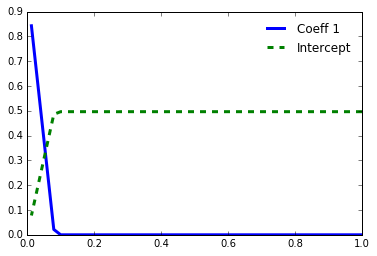

In [14]:
# Plot how lasso coefficients and intercepts depend on alpha selection

# Convenience function for plotting
def plot_alphas_and_coeffs(x, y, model):
    """
    Quickly plot how coefficients depend on alpha selection.
    """
    # Get alphas and preallocate lists
    alphas = 10 ** - np.arange(0, 2, .1)
    coeffs = [[] for idx in range(x.shape[1])]
    ints = []
    # Step through alphas, storing coeffs and ints
    for i, alpha in enumerate(alphas):
        model_ = model(alpha=alpha)
        model_.fit(x, y)
        for idx, coeff in enumerate(model_.coef_):
            coeffs[idx].append(coeff)
        ints.append(model_.intercept_)
    for idx, coeff in enumerate(coeffs):
        plt.plot(alphas, coeff, label='Coeff ' + str(idx+1), linewidth=3)
    plt.plot(alphas, ints, label='Intercept', linestyle='--', linewidth=3)
    plt.legend(loc='best', frameon=False)
    

plot_alphas_and_coeffs(x, y, linear_model.Lasso)

The coefficient of x in our model, or the slope of the line above, is dependent on alpha. Higher values of alpha lead to lower coefficient values. We could choose alpha via cross-validation and do much better:

Validated alpha value:  3.16227766017e-10


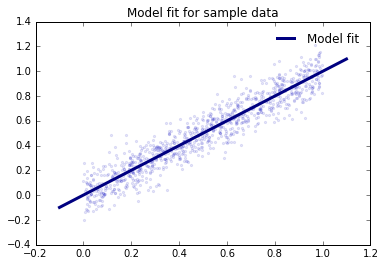

In [15]:
# Choose a better alpha
alphas = 10 ** - np.arange(0, 10, .5)
model_lasso = linear_model.LassoCV(alphas=alphas)
model_lasso.fit(x, y.ravel())

print 'Validated alpha value: ', model_lasso.alpha_

plot_data_and_model(x, y, model_lasso)

### Model parameters with more variables

What does this look like for datasets with more variables? Well, for ridge regression:

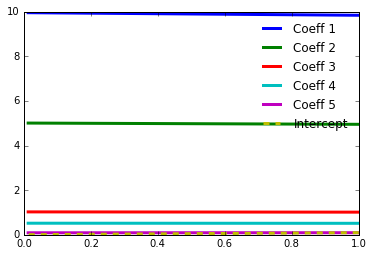

In [16]:
# What does this look like for larger datasets?

linear_coeffs = [10, 5, 1, .5, .1]
x, y = generate_sample_dataset(_NUM_DATAPOINTS, linear_coeffs, _NOISE_PARAMS)

plot_alphas_and_coeffs(x, y, linear_model.Ridge)

Note that, in this case, model fit is not particularly sensitive to alpha selection. For lasso regression:

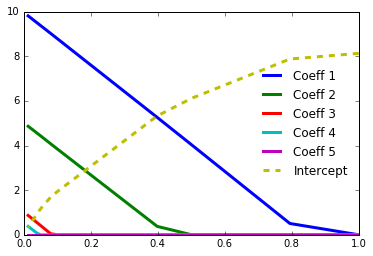

In [17]:
plot_alphas_and_coeffs(x, y, linear_model.Lasso)

Remember that these were the coefficients we used to generate sample data:

In [18]:
print linear_coeffs

[10, 5, 1, 0.5, 0.1]


The variable with the smallest correlation drops out of the lasso model first, the variable with the largest correlation drops out last. After all variables have been dropped, the intercept is the only informative piece of information.

Scikit-learn has so many more <a href='http://scikit-learn.org/stable/modules/linear_model.html'>options for linear models</a>, but it's nice to start with something simple and get more complicated when necessary.